In [1]:
# various import statements
import os
import sklearn
from sklearn import cluster
import pandas as pd
import scanpy as sc
import scvi
import inspect
import tqdm
import numpy as np
from collections import defaultdict
import torch
import torch.nn as nn
from torch.nn.functional import softplus, softmax
from torch.distributions import constraints
import seaborn
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.optim
from pyro.infer import SVI
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re

sc.settings.figdir=os.path.expanduser('~/WbFigures/SpeciesDivergenceNoScaling')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

cuda:0


In [2]:
import sys
sys.path.append('/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/')
import antipode_model
from antipode_model import *
import model_functions
from model_functions import *
import model_distributions
from model_distributions import *
import model_modules
from model_modules import *
import train_utils
from train_utils import *
import plotting
from plotting import *

import importlib
antipode_model=importlib.reload(antipode_model)
from antipode_model import *

import importlib
model_modules=importlib.reload(model_modules)
from model_modules import *

model_functions=importlib.reload(model_functions)
from model_functions import *

import importlib
model_distributions=importlib.reload(model_distributions)
from model_distributions import *

import importlib
train_utils=importlib.reload(train_utils)
from train_utils import *

import importlib
plotting=importlib.reload(plotting)
from plotting import *



In [3]:
# adata=sc.read_h5ad(os.path.expanduser('/home/matthew.schmitz/Matthew/data/cortex_data/v1_combination.h5ad'),backed='r')
# adata=adata[~adata.obs['dataset'].isin(['jorstad_cross_areal','krienen_marmoset']),:]
# adata.write_h5ad(os.path.expanduser('/home/matthew.schmitz/Matthew/data/cortex_data/v1_combination_nojo.h5ad'))

In [4]:
adata=sc.read_h5ad(os.path.expanduser('/home/matthew.schmitz/Matthew/data/cortex_data/v1_combination_nojo.h5ad'),backed='r')
adata

AnnData object with n_obs × n_vars = 464337 × 10019 backed at '/home/matthew.schmitz/Matthew/data/cortex_data/v1_combination_nojo.h5ad'
    obs: 'batch', 'species', 'dataset'
    var: 'homo_sapiens_symbol', 'tupaia_belangeri_ensemblid', 'rousettus_aegyptiacus_ensemblid', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'featureid', 'highly_variable_features', 'hvf_loess', 'hvf_rank', 'mean', 'n_cells', 'percent_cells', 'robust', 'var', 'gene_name', 'gene', 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'Accession'
    layers: 'UMIs'

/scratch/fast/14196289/ipykernel_70404/4204919228.py:1: DtypeWarning: Columns (20,30,124,171) have mixed types. Specify dtype option on import or set low_memory=False.
  mousemeta=pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/cortex_data/internal_mouse/VISp_multiome_metadata_mouse.csv')
 14%|█▎        | 13715/100000 [09:46<1:01:31, 23.37it/s]


KeyError: 'kmeans'

In [5]:
adata.uns['species_colors']=['blue','red','green','yellow','orange','pink','turquoise','magenta']

In [6]:
try:
    pyro.clear_param_store()
    del antipode_model
    torch.cuda.empty_cache()
except:
    pass

In [7]:
num_var=adata.shape[1]
batch_size=32
level_sizes=[1,10,30,125]
num_latent=200
num_labels=sum(level_sizes)
steps=0
max_steps=100000
print_every=5000

# Clear Pyro param store so we don't conflict with previous run
pyro.clear_param_store()
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(False)

decay_function=gen_linear_function(max_steps,max_steps//10)#gen_exponential_decay(5e-6)

# Instantiate instance of model/guide and various neural networks
antipode_model = ANTIPODE(num_latent=num_latent,level_sizes=level_sizes,
                adata=adata,discov_pair=('obs','species'),batch_pair=('obs','batch'),layer='UMIs',
                scale_factor=1e2 / (3*batch_size * num_var * num_labels * num_latent),
                bi_depth=2,decay_function=decay_function,max_strictness=100,prior_scale=100.,num_batch_embed=10,phase1_treeest=True)


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

I0000 00:00:1706685671.919697   70404 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Training Phase 1: Particlized tree approximation

In [16]:
antipode_model.train_phase_1(max_steps=max_steps,print_every=10000,num_particles=1)
antipode_model.store_outputs(device=device,prefix='')


INFO     Generating sequential column names                                                                        



 43%|████▎     | 42825/100000 [26:20<35:09, 27.10it/s]

100%|██████████| 227/227 [00:01<00:00, 164.48it/s]


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


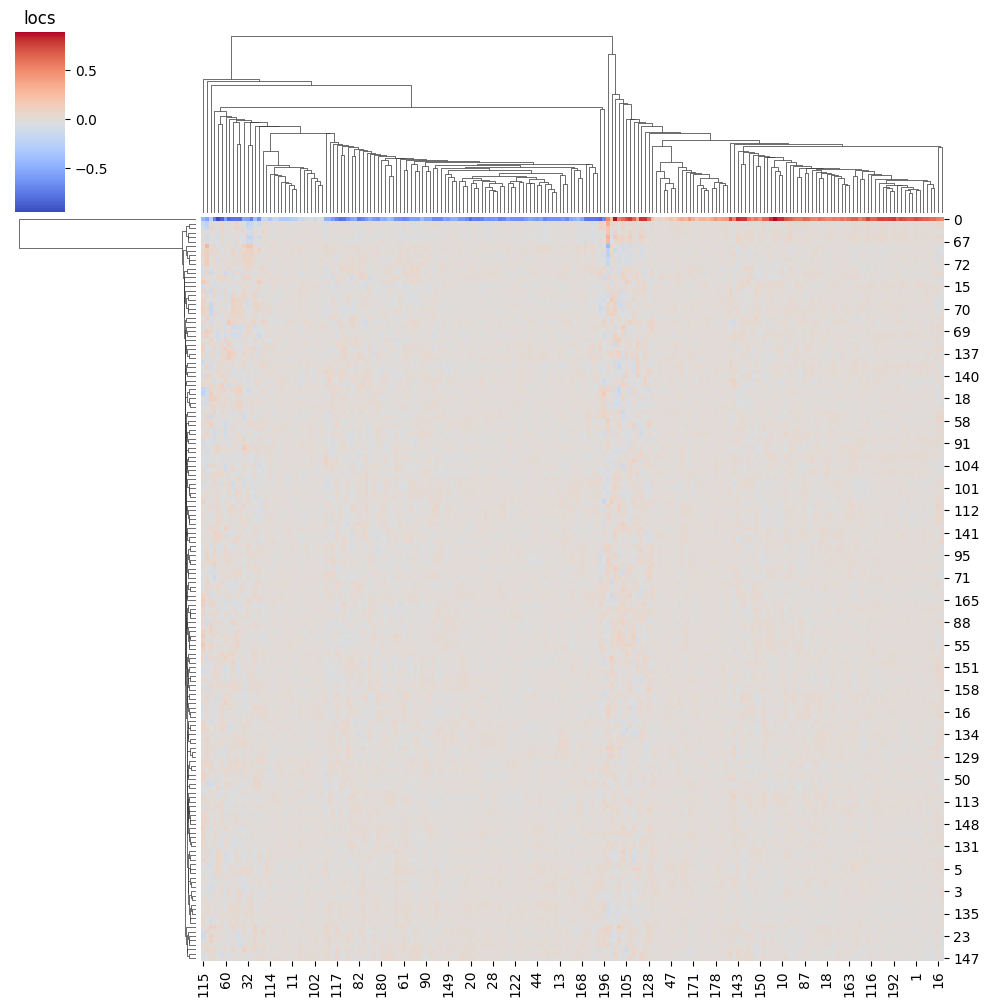

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


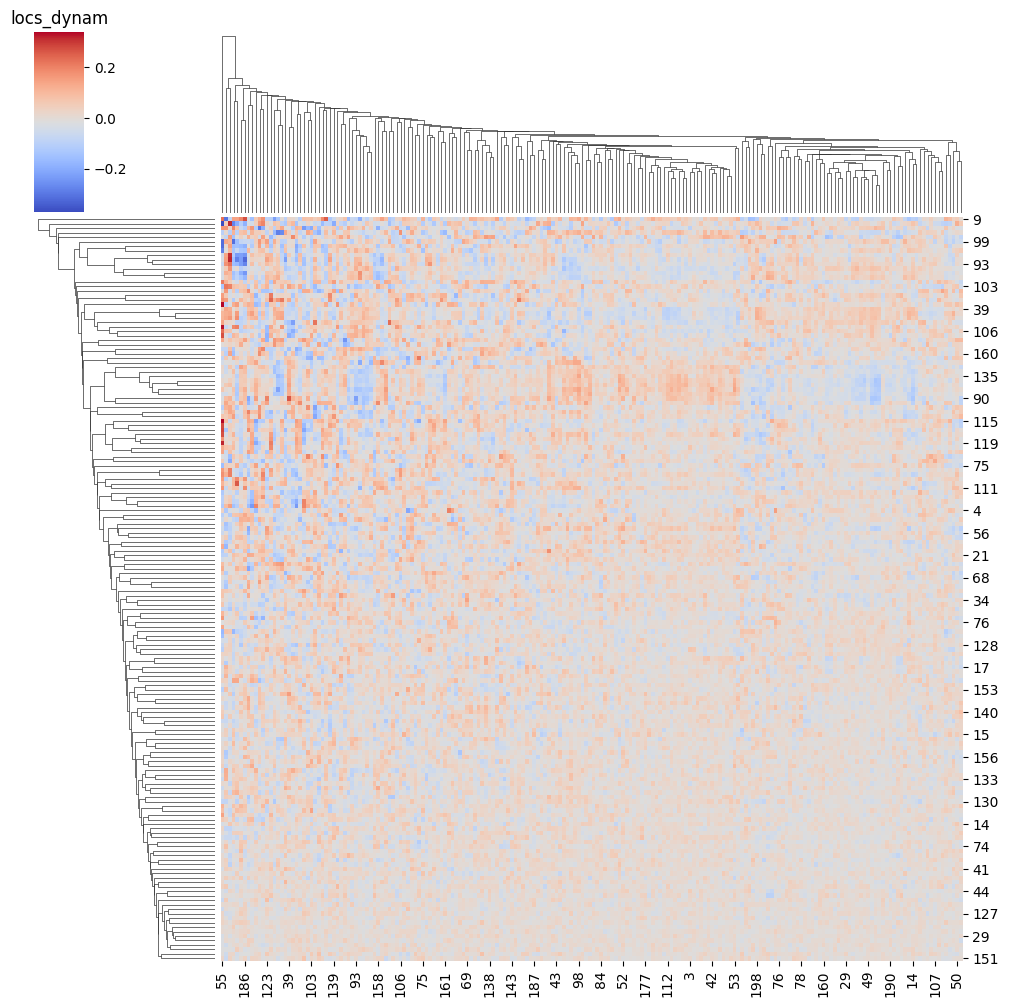

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


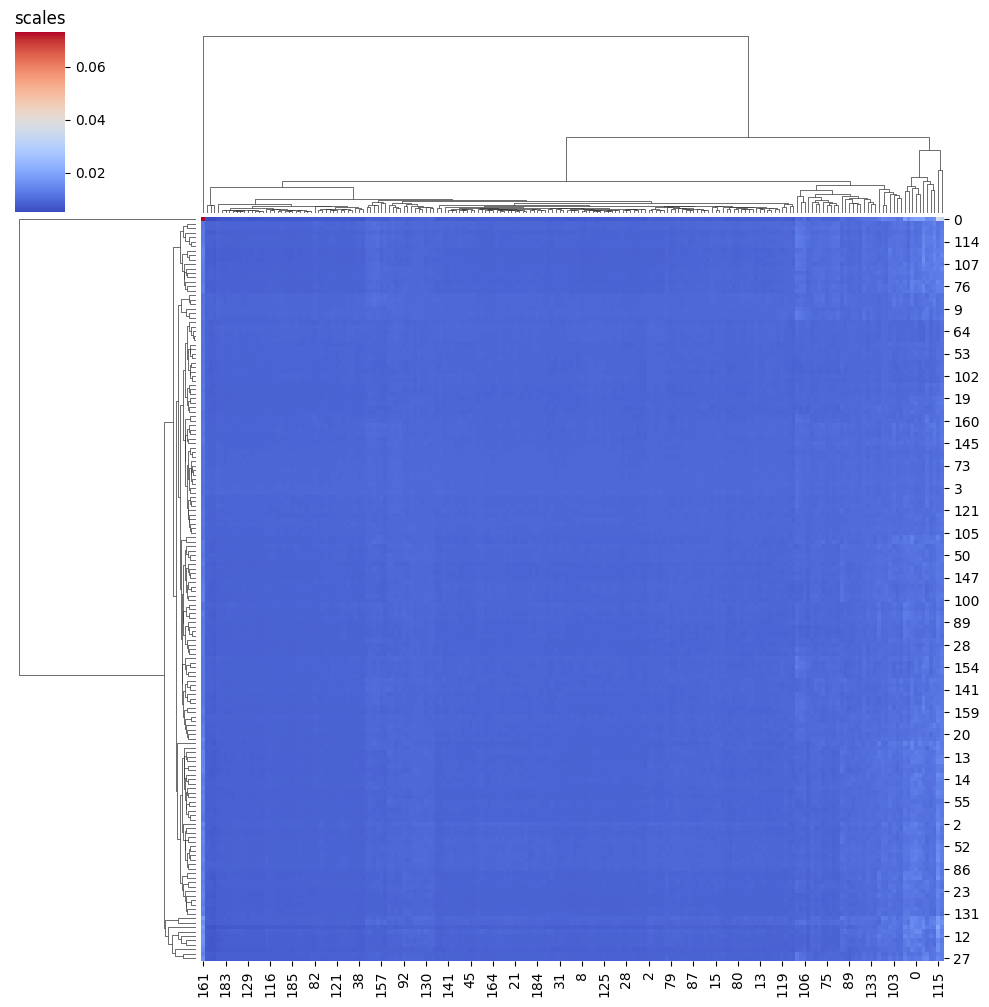

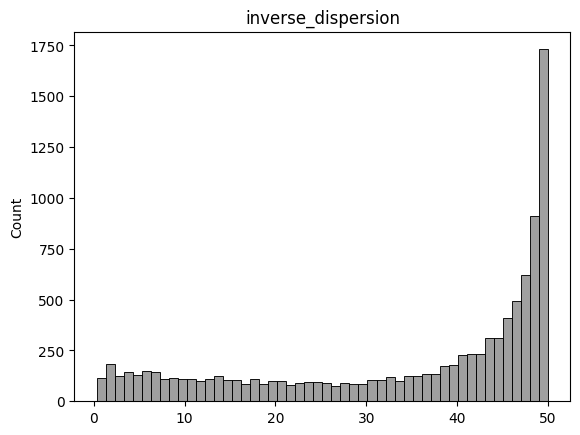

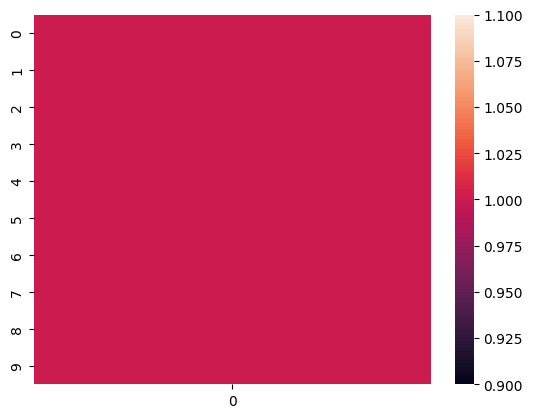

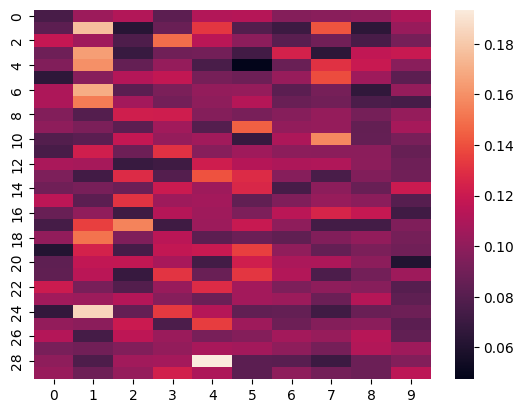

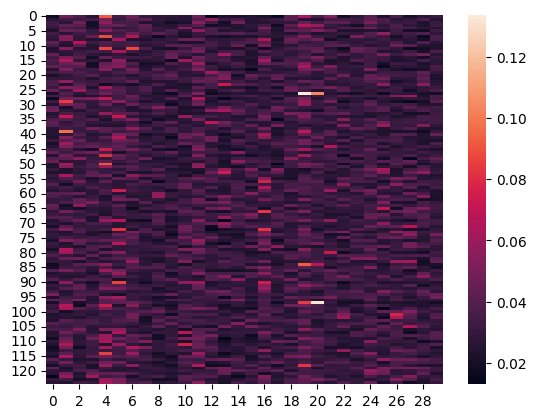

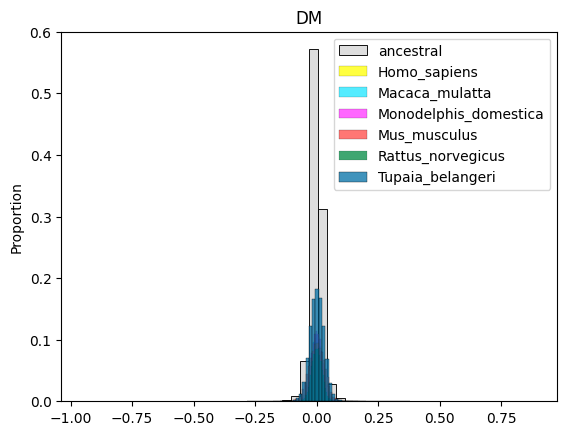

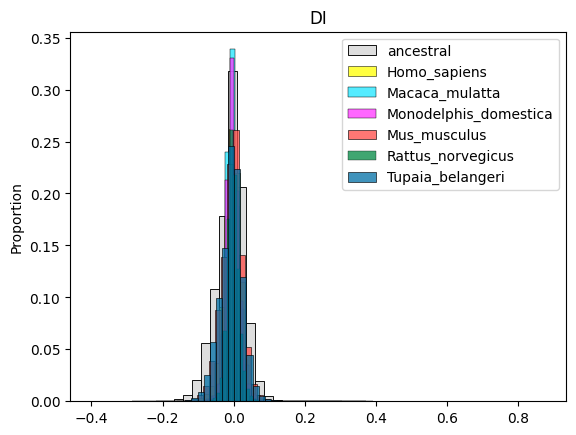

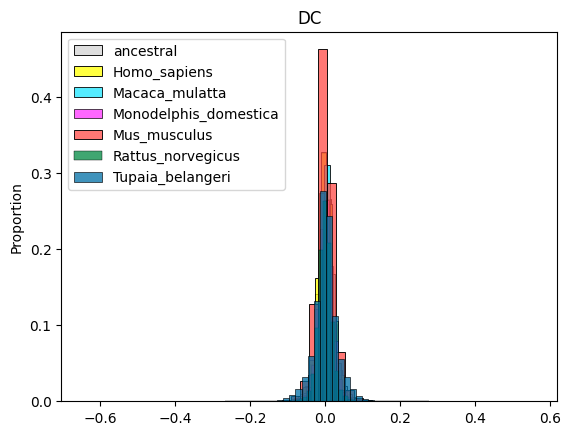

In [17]:
plot_gmm_heatmaps(antipode_model)
plot_tree_edge_weights(antipode_model)
plot_d_hists(antipode_model)

Jan 31 12:04:09 AM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Jan 31 12:04:09 AM: The following items have duplicates [ 47318  47321  47323 ... 110055 110057 110058]


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


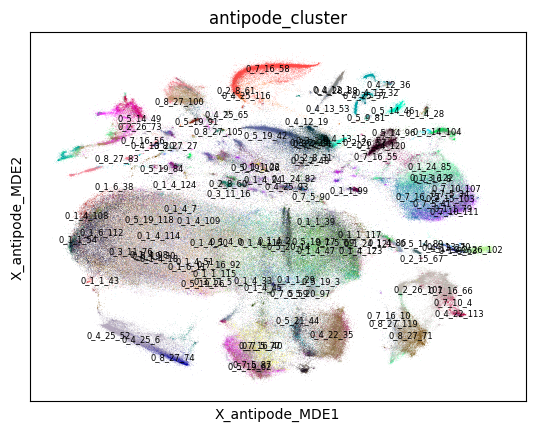

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


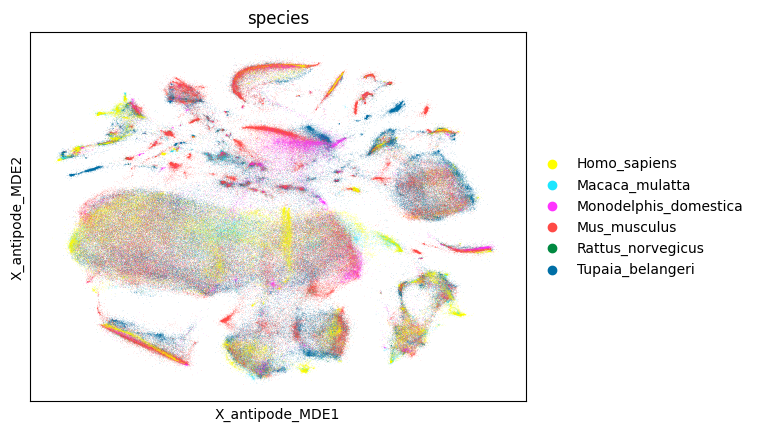

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


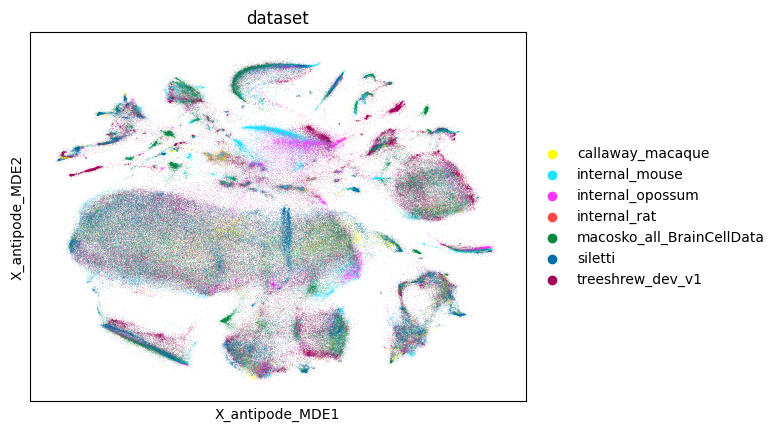

In [18]:
MDE_KEY = "X_antipode_MDE"
adata.obsm[MDE_KEY] = scvi.model.utils.mde(adata.obsm['X_antipode'])
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["species"],palette=sc.pl.palettes.godsnot_102
)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['dataset'],palette=sc.pl.palettes.godsnot_102
)



/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

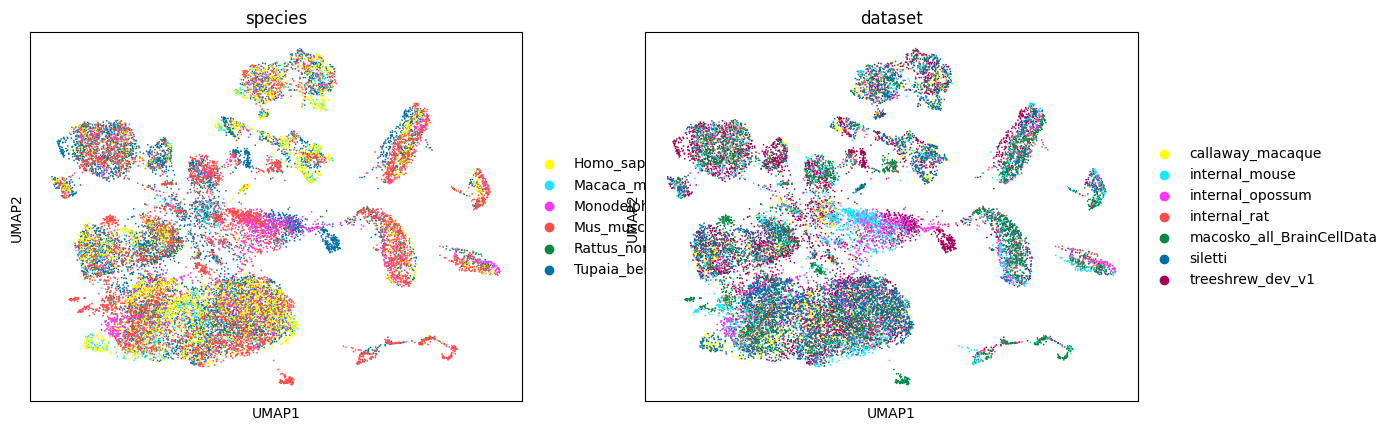

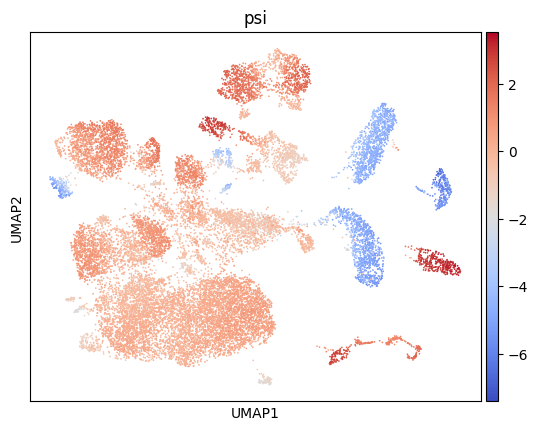

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

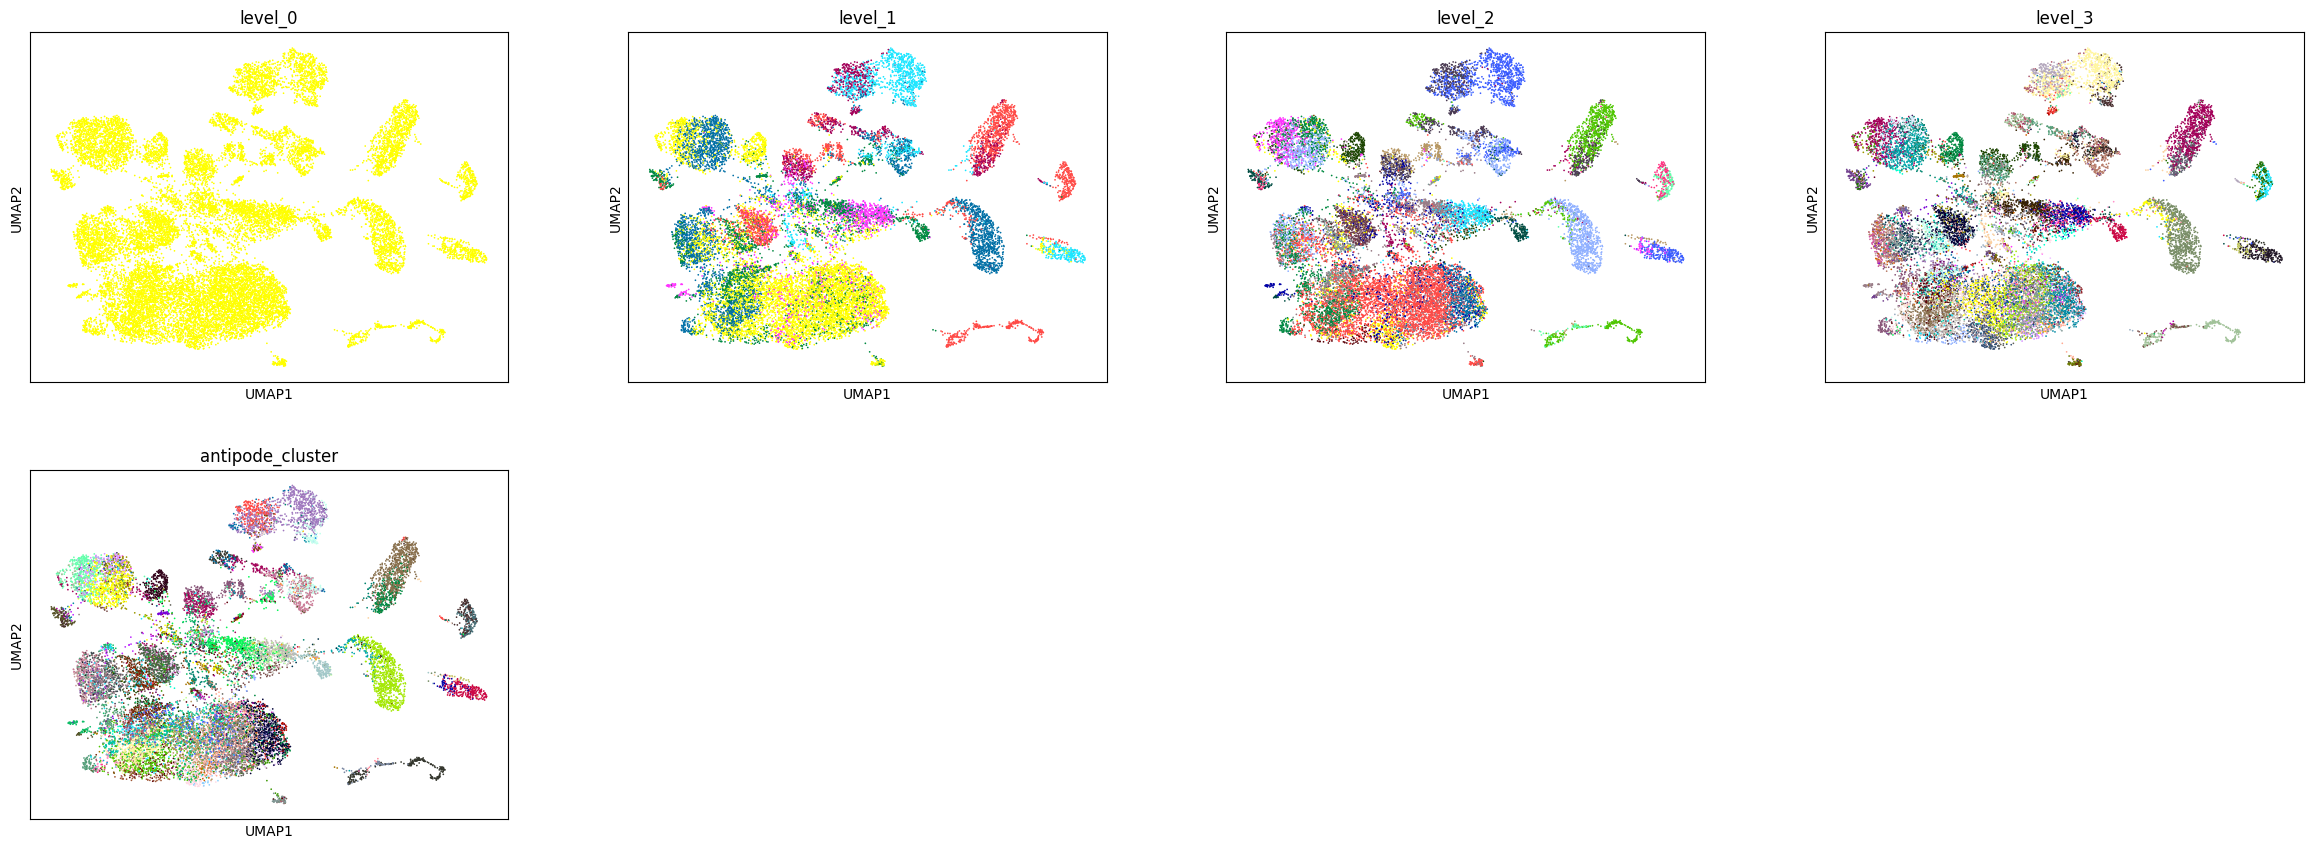

In [19]:
#sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)
random_choice=np.random.choice(adata.obs.index,size=20000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode")
sc.tl.umap(xdata)
sc.pl.umap(xdata,color=['species','dataset'],use_raw=False,palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,legend_loc='on data',cmap='coolwarm')
sc.pl.umap(xdata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)
# xdata.X=xdata.layers['UMIs']
# sc.pp.normalize_per_cell(xdata)
# sc.pp.log1p(xdata)
# sc.pp.scale(xdata,max_value=10)
#sc.pl.umap(xdata,color=['GBX2','EOMES','SIX3','OTX2','FOXG1','RBFOX3','TH','PDGFRA','AQP4','FOXJ1','AIF1','TTR','MOG','COL1A2','CD34','COL4A1','NPY','NKX2-1','FOXP2','SATB2','RORB','FEZF2','EMX1'],use_raw=False,cmap='Purples')
#sc.pl.umap(xdata,color=['DLX2','PROX1','SCGN','TSHZ1','MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67'],cmap='Purples',use_raw=False)
#sc.pl.umap(xdata,color=['RPL7','RPS17','RPL13A','MEF2C'],cmap='Purples',use_raw=False)


# Training Phase 2: Inintializing categorical layered tree

In [ ]:
antipode_model.prepare_phase_2()
#sc.pl.umap(adata,color=['kmeans'],legend_loc="on data",palette=sc.pl.palettes.godsnot_102)
adata.obs['kmeans']=adata.obs['kmeans'].astype('category')
antipode_model.train_phase_2(max_steps=max_steps,print_every=10000,num_particles=1)
antipode_model.store_outputs(device=device,prefix='')


In [ ]:
plot_gmm_heatmaps(antipode_model)
plot_tree_edge_weights(antipode_model)
plot_d_hists(antipode_model)

In [ ]:
mousemeta=pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/cortex_data/internal_mouse/VISp_multiome_metadata_mouse.csv')
mousemeta.index=mousemeta['sample_id']
adata.obs['AIT21_subclass']=mousemeta['subclass_label_AIT21_rc_map']
kmeans_to_subclass=adata.obs.groupby('kmeans')['AIT21_subclass'].value_counts().unstack().idxmax(1).to_dict()
adata.obs['est_AIT21_subclass']=adata.obs['kmeans'].replace(kmeans_to_subclass)

In [ ]:
MDE_KEY = "X_antipode_MDE"
adata.obsm[MDE_KEY] = scvi.model.utils.mde(adata.obsm['X_antipode'])
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster","kmeans"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["species"],palette=sc.pl.palettes.godsnot_102
)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['dataset'],palette=sc.pl.palettes.godsnot_102
)


In [ ]:
#sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_cluster','kmeans'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)
random_choice=np.random.choice(adata.obs.index,size=10000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode")
sc.tl.umap(xdata)
sc.pl.umap(xdata,color=['species'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,legend_loc='on data',cmap='coolwarm')
sc.pl.umap(xdata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)
# xdata.X=xdata.layers['UMIs']
# sc.pp.normalize_per_cell(xdata)
# sc.pp.log1p(xdata)
# sc.pp.scale(xdata,max_value=10)
#sc.pl.umap(xdata,color=['GBX2','EOMES','SIX3','OTX2','FOXG1','RBFOX3','TH','PDGFRA','AQP4','FOXJ1','AIF1','TTR','MOG','COL1A2','CD34','COL4A1','NPY','NKX2-1','FOXP2','SATB2','RORB','FEZF2','EMX1'],use_raw=False,cmap='Purples')
#sc.pl.umap(xdata,color=['DLX2','PROX1','SCGN','TSHZ1','MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67'],cmap='Purples',use_raw=False)
#sc.pl.umap(xdata,color=['RPL7','RPS17','RPL13A','MEF2C'],cmap='Purples',use_raw=False)


# Training Phase 3: Refining the final tree

In [ ]:
antipode_model.train_phase_3(max_steps=max_steps,print_every=10000,num_particles=3)
antipode_model.store_outputs(device=device,prefix='')

In [ ]:
plot_gmm_heatmaps(antipode_model)
plot_tree_edge_weights(antipode_model)
plot_d_hists(antipode_model)

 43%|████▎     | 42825/100000 [25:50<34:03, 27.97it/s]

In [ ]:
MDE_KEY = "X_antipode_MDE"
adata.obsm[MDE_KEY] = scvi.model.utils.mde(adata.obsm['X_antipode'])
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster","kmeans"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["species"],palette=sc.pl.palettes.godsnot_102
)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['dataset'],palette=sc.pl.palettes.godsnot_102
)


In [ ]:
#sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_cluster','kmeans'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

random_choice=np.random.choice(adata.obs.index,size=100000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode")
sc.tl.umap(xdata)

sc.pl.umap(xdata,color=['species'],use_raw=False,palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,cmap='coolwarm')
sc.pl.umap(xdata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)
xdata.X=xdata.layers['UMIs'].todense().float()
sc.pp.normalize_per_cell(xdata)
sc.pp.log1p(xdata)
sc.pp.scale(xdata,max_value=10)


In [ ]:
gene_list=['RBFOX3','PDGFRA','AQP4','FOXJ1','AIF1','MOG','COL1A2','CD34','COL4A1','NPY','FOXP2','SATB2','RORB','DLX2','PROX1','SCGN','TSHZ1','SLC17A7','TLE4',
           'MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67','RPL7','RPS17','RPL13A','MEF2C']
gene_list=[x for x in gene_list if x in xdata.var.index]
sc.pl.umap(xdata,color=gene_list,cmap='Purples',use_raw=False)

In [ ]:
#adata.write_h5ad('/home/matthew.schmitz/Matthew/1.9.1_run.h5ad')

In [ ]:
xdata.obs['log_n_umi']=np.log10(xdata.X.sum(1)+1)
sc.pl.violin(xdata,groupby='dataset',keys='log_n_umi',rotation=90)

In [ ]:
sc.pl.umap(xdata,color=[x for x in adata.obs.columns if 'level' in x][1:]+['antipode_cluster'],use_raw=False,legend_loc='on data',legend_fontsize=6,legend_fontweight='normal',palette=sc.pl.palettes.godsnot_102)


In [ ]:
adata.obs

In [ ]:
cluster_colors

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example data
np.random.seed(0)
data = adata.uns['param_store']['discov_dm'].var(-1)[:,-antipode_model.level_sizes[-1]:]
species = antipode_model.adata_manager.registry['field_registries']['discov_ind']['state_registry']['categorical_mapping']
clusters = [f'Cluster_{i}' for i in range(data.shape[-1])]

df = pd.DataFrame(data, index=species, columns=clusters)

# Annotations for clusters (assuming each cluster has a unique color)
cluster_colors = adata.uns['level_3_colors']
cluster_lut = dict(zip(map(str, clusters), cluster_colors))
cluster_colors = pd.Series(df.columns, index=df.columns).map(cluster_lut)
cluster_colors=cluster_colors.fillna('white')

# Annotations for predicted subclasses (assuming each subclass has a unique color)
# Replace 'subclass_values' with your actual subclass values
level_to_subclass=adata.obs.groupby('level_3')['AIT21_subclass'].value_counts().unstack().idxmax(1)
level_to_subclass.index=list(level_to_subclass.index.astype(int))
for k in range(antipode_model.level_sizes[-1]):
    if k not in level_to_subclass.keys():
        level_to_subclass[k]='nan'
subclasses=[level_to_subclass[k] for k in range(antipode_model.level_sizes[-1])]
subclass_colors = [sc.pl.palettes.godsnot_102[x%len(sc.pl.palettes.godsnot_102)] for x in range(len(sc.pl.palettes.godsnot_102))]#sns.color_palette("Set2", len(subclasses))
subclass_lut = dict(zip(subclasses, subclass_colors))
subclass_lut['nan']='white'
subclass_colors = pd.Series(subclasses, index=df.columns).map(subclass_lut)

# Concatenate the color annotations into a single DataFrame
# Assuming you want these annotations for rows (species)
row_colors = pd.DataFrame({'Subclass': subclass_colors,'Cluster': cluster_colors})
print(row_colors)

# Create the clustermap
g = sns.clustermap(df, col_colors=row_colors, figsize=(12, 8))

# Create a legend for the colors
for label, color in subclass_lut.items():
    g.ax_col_dendrogram.bar(0, 0, color=color, label=label, linewidth=0)
g.ax_col_dendrogram.legend(title="Predicted Subclasses", loc="center", bbox_to_anchor=(0.5, 1.15), ncol=3)

plt.show()


In [ ]:
adata